# aSPEM Experiment : analysis


Test de différtentes pentes $k$ pour la relation entre $p_bet$ et $\hat{p}$


In [1]:
%run ../0_parameters.ipynb


WELCOME

2020-03-06T10:04:34+01:00

CPython 3.5.2
IPython 5.3.0

numpy 1.16.3
matplotlib 3.0.3
torch 1.1.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-83-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
host name  : INV-OPE-HP01
Git hash   : cef230850aac5d9cb4d22cd6deafc0ad7237d08f
Git repo   : https://github.com/chloepasturel/AnticipatorySPEM.git
Git branch : master


In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('../data/*pkl'):
    a = fname.split('/')[2].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


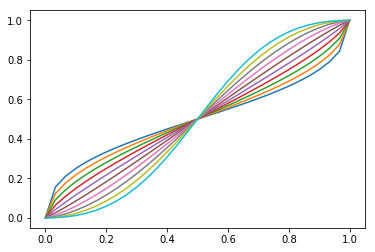

In [5]:
p = np.linspace(0, 1, 31)
def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))
    
#plt.plot(p, sigmoid(4.*logit(p)))
for k in np.logspace(-1, 1, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))

In [6]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [7]:
def find_h_r(recording, pourcentage=0.99) :
    Full = e.Full_list(modes_bcp=[])
    modes_bcp = 'mean'
    list_h = recording['list_h']

    r_k_s, h_k_s = {}, {}
    for num, s in enumerate(list(set(Full.sujet))):
        print(s, end=' ')

        bet = Full['results'][Full.sujet==s].values.tolist()
        x = np.array(Full['bino'][Full.sujet==s].values.tolist())

        r_k, h_k = [], []
        for k in range(11) : r_k.append([]) ; h_k.append([])

        for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :

            r_bet_l, r_bet_ = recording['r_bet_k'][s][k], recording['r_bet_k'][s]['sslogit']


            h_bet_logit, h_bet = [], []
            r_bet_logit, r_bet = [], []
            for d, c in enumerate(range(0, 3*200-150, 200)) :

                if num==0 :

                    if np.argmax(r_bet_[d])==len(list_h)-1 : #pourcentage
                        maxx=None
                        for x in range(len(r_bet_[d])) :
                            if np.round(r_bet_[d][x], 4)==np.round(pourcentage*np.max(r_bet_[d]), 4) : maxx=x
                        if maxx is None :
                            for x in range(len(r_bet_[d])) :
                                if np.round(r_bet_[d][x], 3)==np.round(pourcentage*np.max(r_bet_[d]), 3) : maxx=x
                        if maxx is None :
                            for x in range(len(r_bet_[d])) :
                                if np.round(r_bet_[d][x], 2)==np.round(pourcentage*np.max(r_bet_[d]), 2) : maxx=x
                        if maxx is None :
                            for x in range(len(r_bet_[d])) :
                                if np.round(r_bet_[d][x], 1)==np.round(pourcentage*np.max(r_bet_[d]), 1) : maxx=x
                        
                        r_bet.append(r_bet_[d][maxx])
                        h_bet.append(list_h[maxx])
                    else :
                        h_bet.append(list_h[np.argmax(r_bet_[d])])
                        r_bet.append(np.max(r_bet_[d]))

                if np.argmax(r_bet_l[d])==len(list_h)-1 : #pourcentage
                    maxx=None
                    for x in range(len(r_bet_l[d])) :
                        if np.round(r_bet_l[d][x], 4)==np.round(pourcentage*np.max(r_bet_l[d]), 4) : maxx=x  
                    if maxx is None :
                        for x in range(len(r_bet_l[d])) :
                            if np.round(r_bet_l[d][x], 3)==np.round(pourcentage*np.max(r_bet_l[d]), 3) : maxx=x
                    if maxx is None :
                        for x in range(len(r_bet_l[d])) :
                            if np.round(r_bet_l[d][x], 2)==np.round(pourcentage*np.max(r_bet_l[d]), 2) : maxx=x
                    if maxx is None :
                        for x in range(len(r_bet_l[d])) :
                            if np.round(r_bet_l[d][x], 1)==np.round(pourcentage*np.max(r_bet_l[d]), 1) : maxx=x
                    
                    
                    r_bet_logit.append(r_bet_l[d][maxx])
                    h_bet_logit.append(list_h[maxx])
                else :
                    h_bet_logit.append(list_h[np.argmax(r_bet_l[d])])
                    r_bet_logit.append(np.max(r_bet_l[d]))

            if num==0 : h_k[0]=h_bet; r_k[0]=r_bet
            h_k[num+1]=h_bet_logit ; r_k[num+1]=r_bet_logit

        h_k_s[s], r_k_s[s] = h_k, r_k
    return h_k_s, r_k_s

Plot de R en fonction de la pente

In [8]:
def fig_R_pente(h_k_s, r_k_s, r=True) :
    fig, ax = plt.subplots(1,2,figsize=(2*10,10))

    list_k = np.logspace(-1, 1, 10, base=2)
    print('\nsans logit|avec logit (max r)\n')
    print('\t\tBlock 0\t\t\tBlock 1\t\t\tBlock 2')
    print('-'*85)


    for num, s in enumerate(h_k_s.keys()) :
        h_k, r_k = np.array(h_k_s[s]), np.array(r_k_s[s])

        r0, r1, r2 = np.max(r_k[:, 0]), np.max(r_k[:, 1]), np.max(r_k[:, 2])
        arg0, arg1, arg2 = np.argmax(r_k[:, 0]), np.argmax(r_k[:, 1]), np.argmax(r_k[:, 2])
        h0, h1, h2 = h_k[arg0, 0], h_k[arg1, 1], h_k[arg2, 2]

        if arg0==0 : k0 = 1
        else :       k0 = list_k[arg0-1]

        if arg1==0 : k1 = 1
        else :       k1 = list_k[arg1-1]

        if arg2==0 : k2 = 1
        else :       k2 = list_k[arg2-1]

        print('%s\tk:\t         |%.3f\t\t        |%.3f\t\t        |%.3f'%(s, k0, k1, k2))
        print('\th(tau):\t%.3f(%.0f)|%.3f(%.0f)\t%.3f(%.0f)|%.3f(%.0f)\t%.3f(%.0f)|%.3f(%.0f)'%(h_k[0,0], 1/h_k[0,0], h0, 1/h0,
                                                                                                h_k[0,1], 1/h_k[0,1], h1, 1/h1,
                                                                                                h_k[0,2], 1/h_k[0,2], h2, 1/h2))
        print('\tr:\t%.3f    |%.3f\t\t   %.3f|%.3f\t\t   %.3f|%.3f'%(r_k[0,0], r0, r_k[0,1], r1, r_k[0,2], r2))
        print('-'*85)

        for block, c in zip(range(3), ['k', 'r', 'g']) :
            ax[0].plot(list_k, r_k[1:,block], c=c, label='b%s'%block if num==0 else '')
            ax[1].plot(list_k, h_k[1:,block], c=c, label='b%s'%block if num==0 else '')

    if r==True :
        ax[0].set_ylim(-0.1, 1.1)
        ax[1].set_ylim(-0.01, 0.31)

        ax[0].set_title('R') ; ax[1].set_title('H')
        ax[0].set_ylabel('R') ; ax[1].set_ylabel('H')
    else :
        ax[0].set_title('MI') ; ax[1].set_title('H')
        ax[0].set_ylabel('MI') ; ax[1].set_ylabel('H')
    for a in range(2) : ax[a].legend() ; ax[a].set_xlabel('pente')
    plt.show()

In [9]:
def plot_R(recording, list_x, xlabel, r=True):
    Full = e.Full_list(modes_bcp=[])
    
    fig, ax = plt.subplots(4,3,figsize=(3*6,4*6))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    import matplotlib.gridspec as gridspec

    r_k_s, h_k_s = {}, {}
    for num_s, s in enumerate(list(set(Full.sujet))):
        print(s, end=' ')

        gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=ax[num_s//3][num_s%3], hspace=0.1)

        r_k, h_k = [], []
        for k in range(11) : r_k.append([]) ; h_k.append([])

        for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :

            r_bet_l, r_bet_ = recording['r_bet_k'][s][k], recording['r_bet_k'][s]['sslogit']

            for b in range(3):
                ax_b = plt.subplot(gs[b])
                if num==0 :
                    ax_b.plot(list_x, r_bet_[b], lw=1)
                    ax_b.text(np.max(list_x), 0, 'block %s'%b, ha='right', va='bottom', fontsize=15)
                    if b==0 : ax_b.set_title(s, fontsize=20)
                    if b==2 : ax_b.set_xlabel(xlabel, fontsize=15)
                    else : ax_b.set_xticks(())
                    if r==True :
                        ax_b.set_ylim(0,1)
                        ax_b.set_ylabel('r', fontsize=15)
                    else :
                        ax_b.set_ylabel('MI', fontsize=15)
                    

                ax_b.plot(list_x, r_bet_l[b], lw=1)           
    plt.show()

# R

s02 s11 s07 s04 s03 s06 s05 s09 s10 s12 s08 s01 
sans logit|avec logit (max r)

		Block 0			Block 1			Block 2
-------------------------------------------------------------------------------------
s02	k:	         |0.926		        |0.500		        |0.794
	h(tau):	0.031(32)|0.032(31)	0.014(70)|0.026(39)	0.026(39)|0.026(38)
	r:	0.912    |0.912		   0.949|0.955		   0.926|0.927
-------------------------------------------------------------------------------------
s11	k:	         |0.500		        |1.714		        |1.714
	h(tau):	0.015(65)|0.015(65)	0.043(23)|0.031(32)	0.033(30)|0.034(29)
	r:	0.757    |0.765		   0.881|0.889		   0.870|0.877
-------------------------------------------------------------------------------------
s07	k:	         |0.500		        |0.500		        |0.926
	h(tau):	0.019(52)|0.032(31)	0.083(12)|0.111(9)	0.045(22)|0.043(23)
	r:	0.678    |0.690		   0.926|0.928		   0.909|0.909
-------------------------------------------------------------------------------------
s03	k:	         |0.

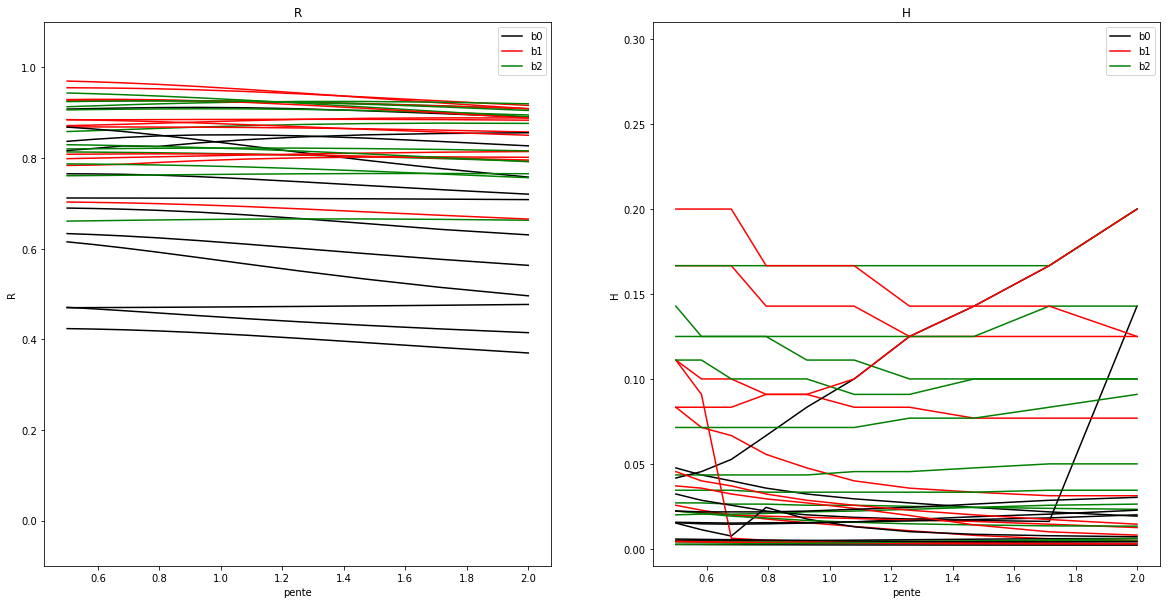

s02 s11 

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


s07 s04 s03 s06 s05 s09 s10 s12 s08 s01 

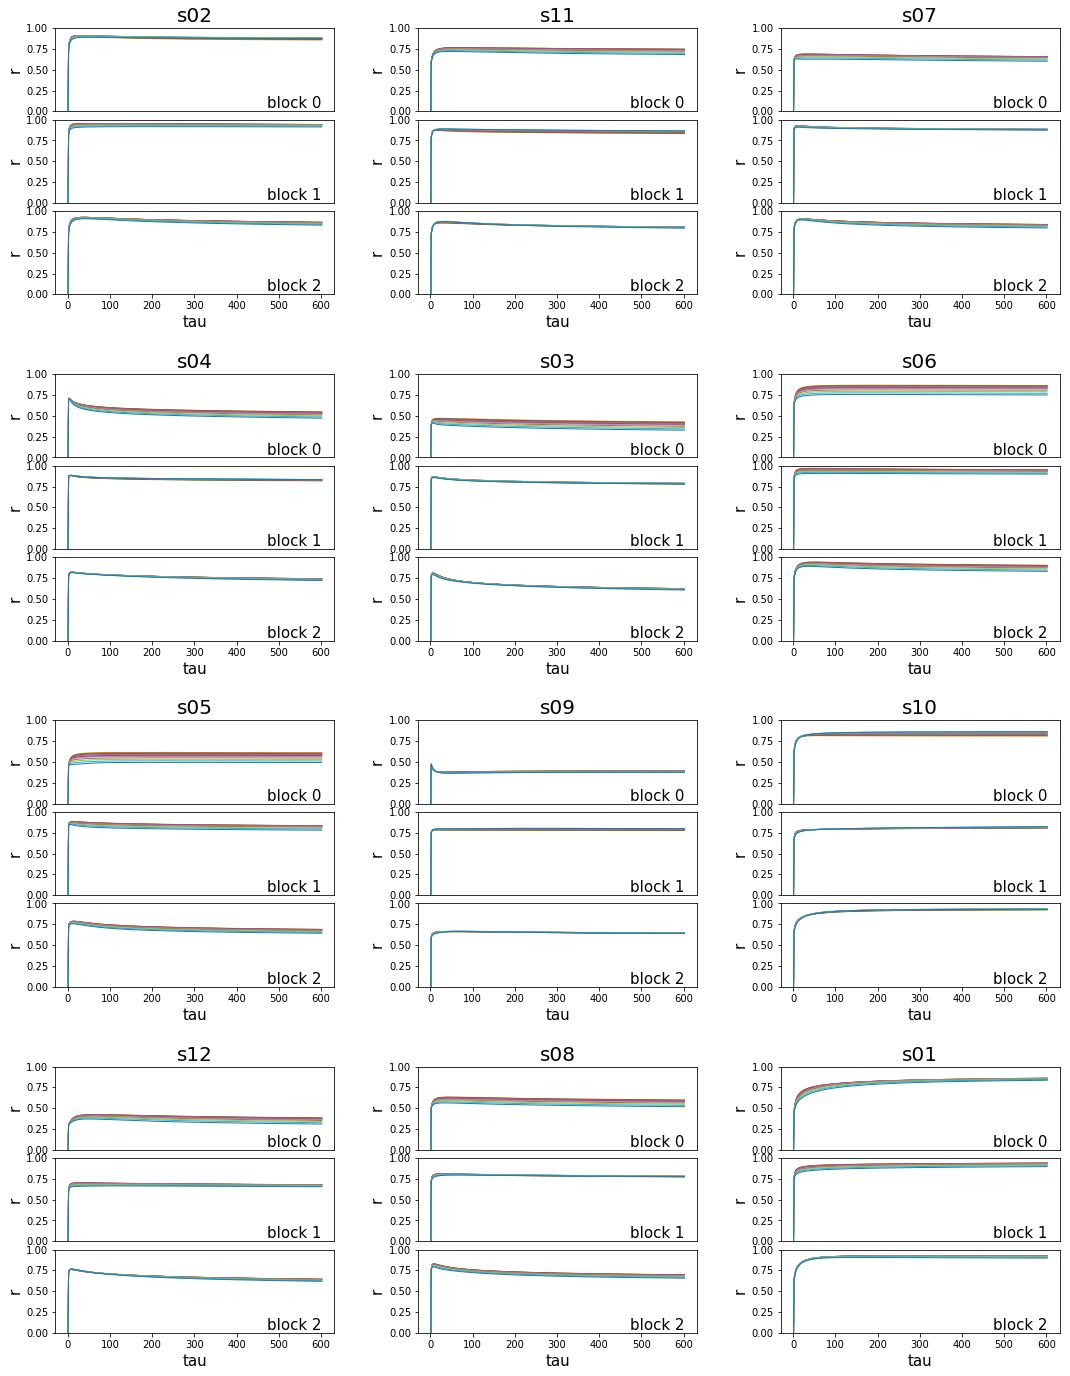

s02 s11 s07 s04 s03 s06 s05 s09 s10 s12 s08 s01 

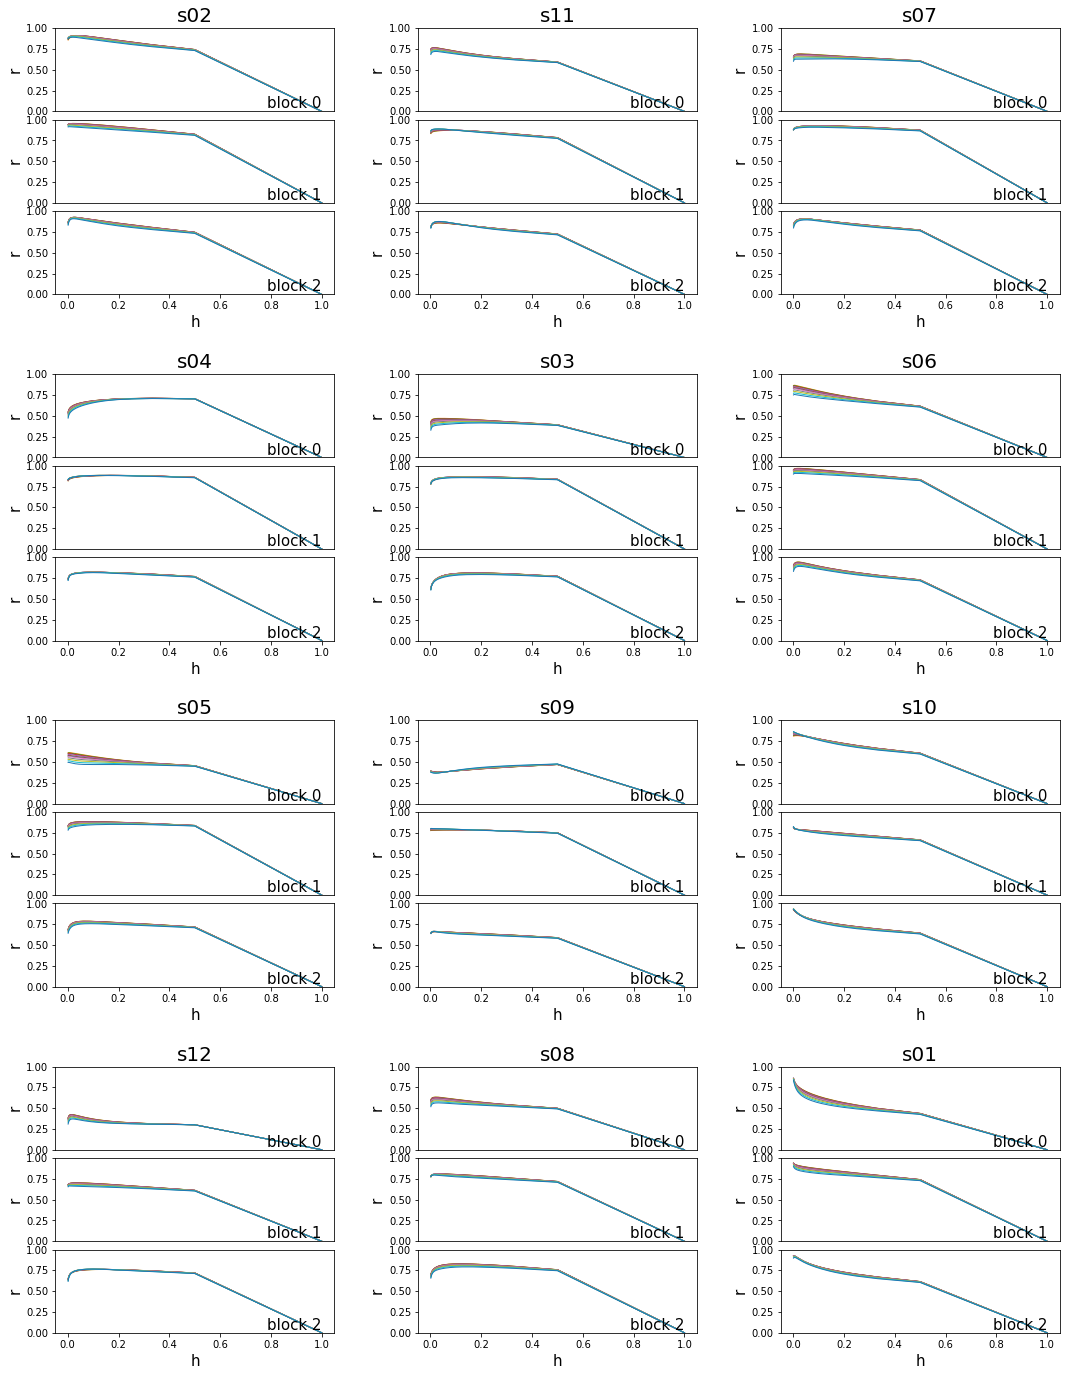

In [10]:
import pickle
file = os.path.join('parametre/list_h', 'list_r_bet_logit_200.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
h_k_s, r_k_s = find_h_r(recording)
fig_R_pente(h_k_s, r_k_s)
plot_R(recording, 1/recording['list_h'], 'tau') 
plot_R(recording, recording['list_h'], 'h') 

s02 s11 s07 s04 s03 s06 s05 s09 s10 s12 s08 s01 
sans logit|avec logit (max r)

		Block 0			Block 1			Block 2
-------------------------------------------------------------------------------------
s02	k:	         |0.500		        |0.680		        |0.680
	h(tau):	0.026(38)|0.029(35)	0.010(98)|0.015(66)	0.026(38)|0.026(39)
	r:	0.897    |0.900		   0.929|0.932		   0.908|0.909
-------------------------------------------------------------------------------------
s11	k:	         |0.500		        |2.000		        |1.714
	h(tau):	0.026(38)|0.029(35)	0.043(23)|0.033(30)	0.029(35)|0.032(31)
	r:	0.722    |0.726		   0.863|0.873		   0.875|0.881
-------------------------------------------------------------------------------------
s07	k:	         |0.500		        |0.500		        |1.080
	h(tau):	0.009(107)|0.012(86)	0.091(11)|0.111(9)	0.050(20)|0.050(20)
	r:	0.706    |0.718		   0.914|0.915		   0.887|0.887
-------------------------------------------------------------------------------------
s03	k:	         |0

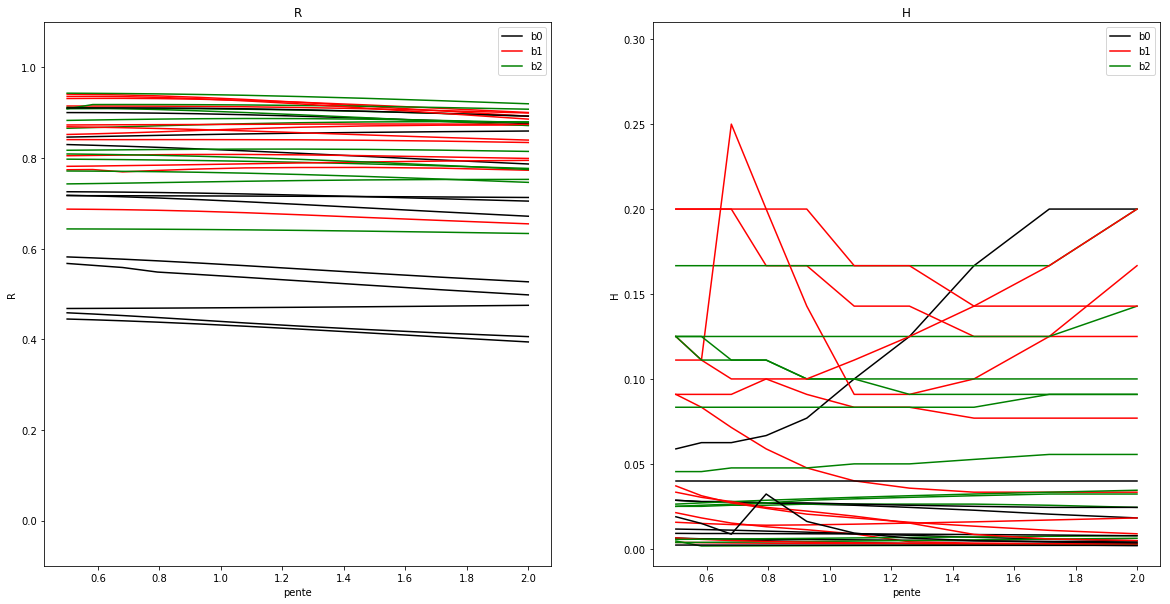

s02 s11 s07 

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


s04 s03 s06 s05 s09 s10 s12 s08 s01 

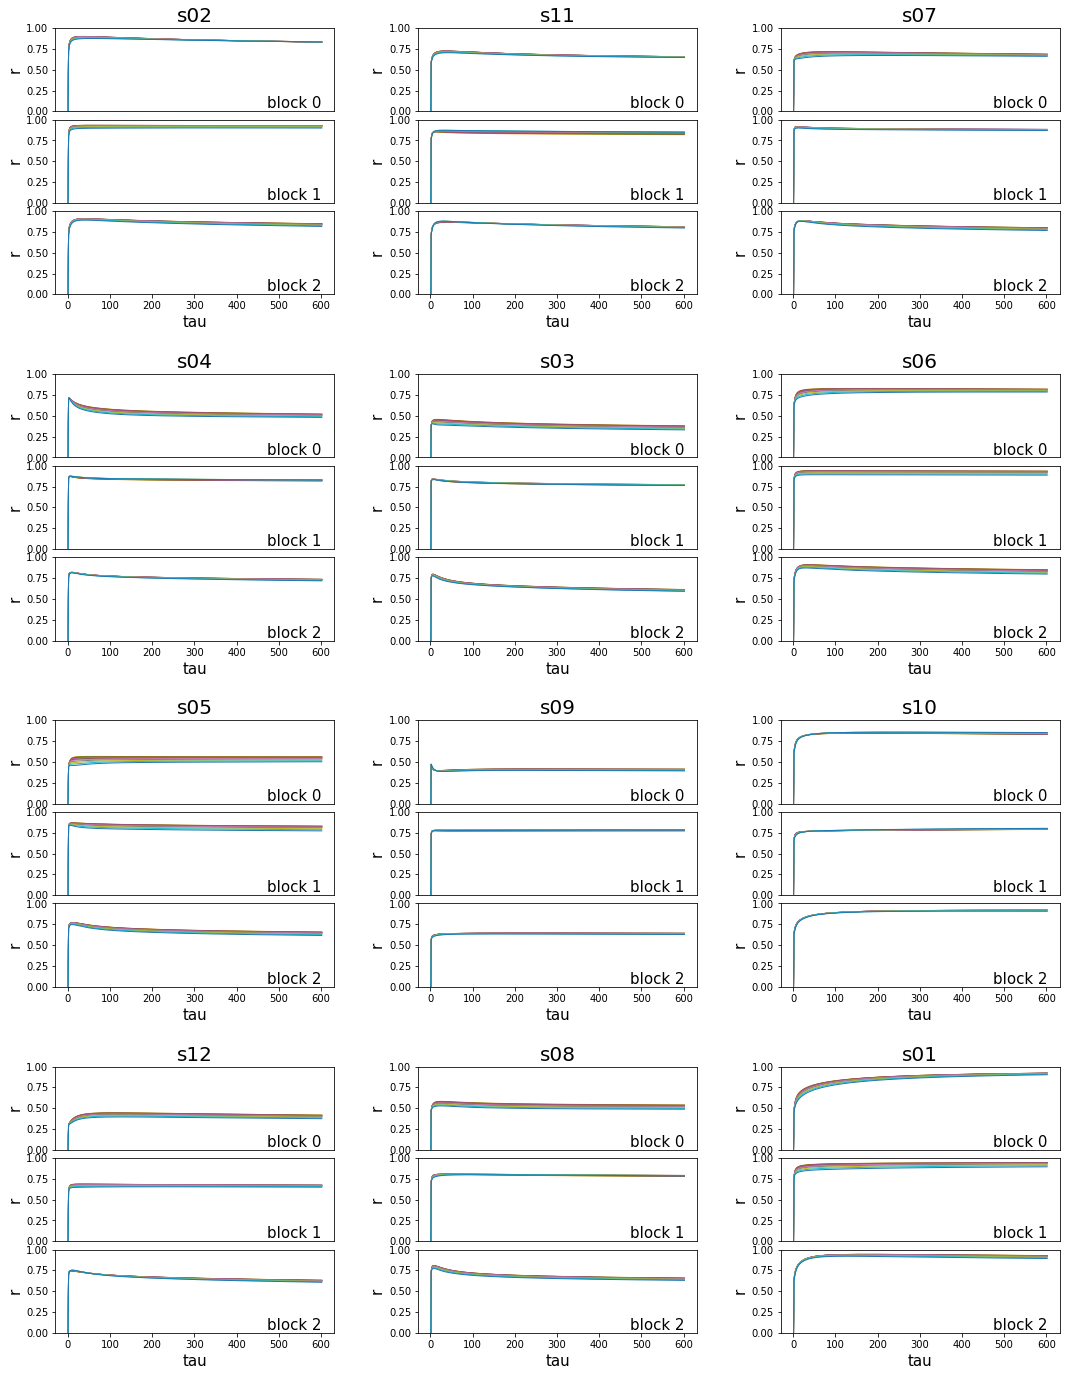

s02 s11 s07 s04 s03 s06 s05 s09 s10 s12 s08 s01 

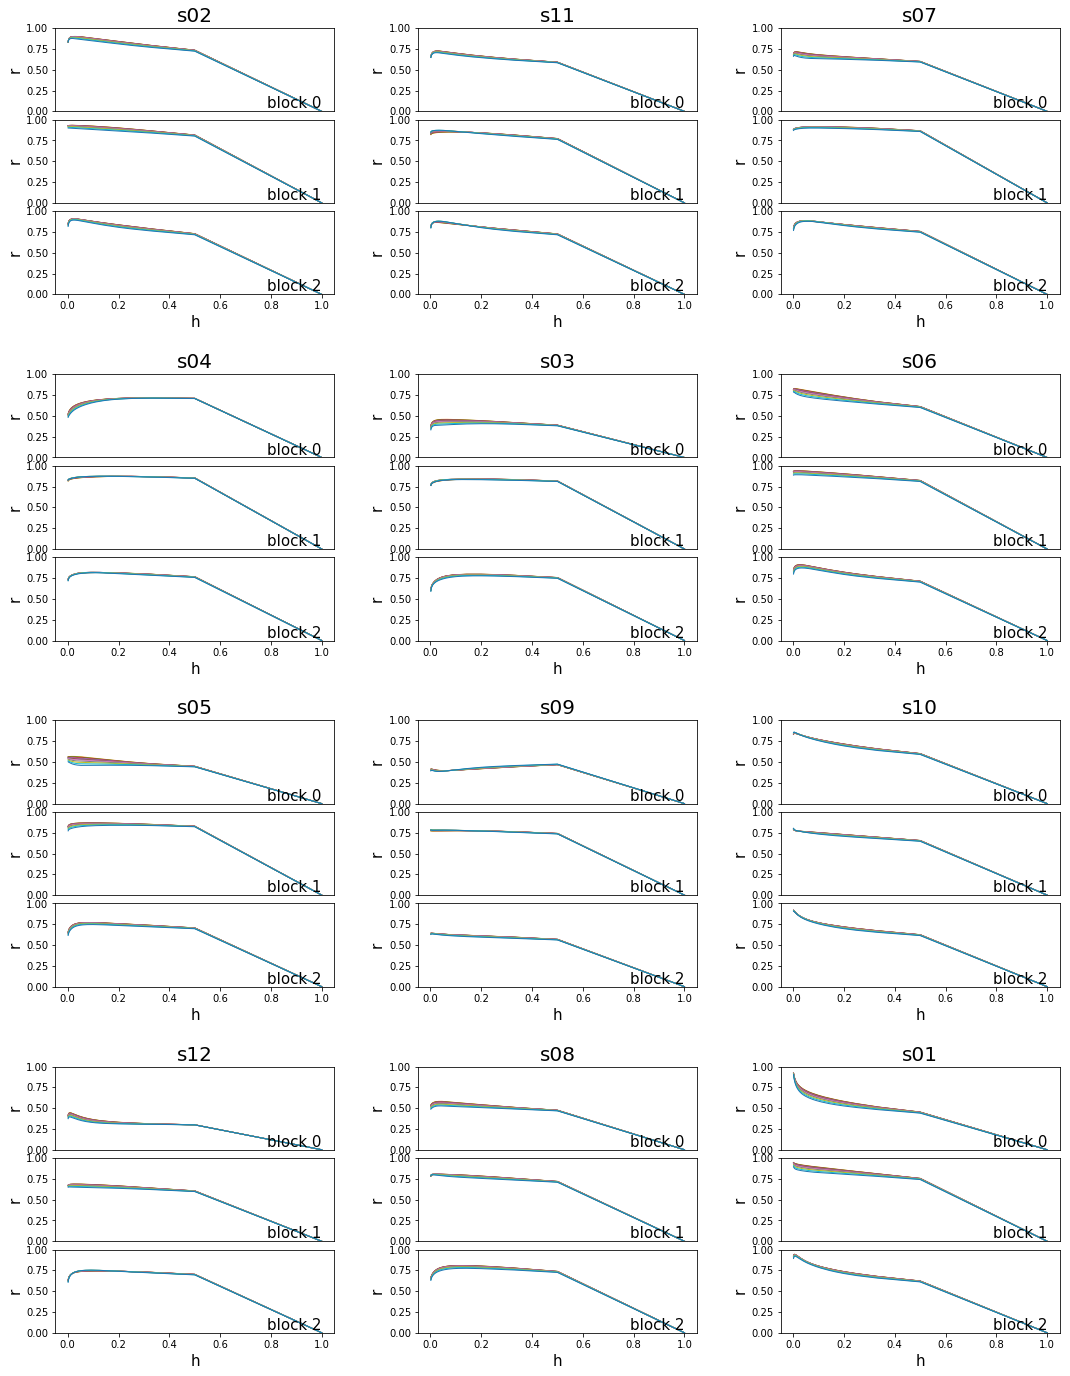

In [11]:
import pickle
file = os.path.join('parametre/list_h', 'list_r_bet_logit_200_ss_pauses.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
h_k_s, r_k_s = find_h_r(recording)
fig_R_pente(h_k_s, r_k_s)
plot_R(recording, 1/recording['list_h'], 'tau') 
plot_R(recording, recording['list_h'], 'h') 

# MI

CS LB BMC OP AM RS TN SR YK FM DC IP 
sans logit|avec logit (max r)

		Block 0			Block 1			Block 2
-------------------------------------------------------------------------------------
CS	k:	         |0.500		        |0.500		        |0.583
	h(tau):	0.045(22)|0.008(124)	0.062(16)|0.077(13)	0.200(5)|0.200(5)
	r:	0.167    |0.243		   0.784|0.862		   0.657|0.677
-------------------------------------------------------------------------------------
LB	k:	         |0.926		        |0.500		        |1.000
	h(tau):	0.042(24)|0.043(23)	0.200(5)|0.111(9)	0.042(24)|0.042(24)
	r:	0.495    |0.505		   1.030|1.042		   1.014|1.014
-------------------------------------------------------------------------------------
BMC	k:	         |1.000		        |0.500		        |0.794
	h(tau):	0.024(42)|0.024(42)	0.014(71)|0.056(18)	0.023(43)|0.018(55)
	r:	1.023    |1.023		   1.292|1.334		   0.998|1.054
-------------------------------------------------------------------------------------
OP	k:	         |0.500		        |0.

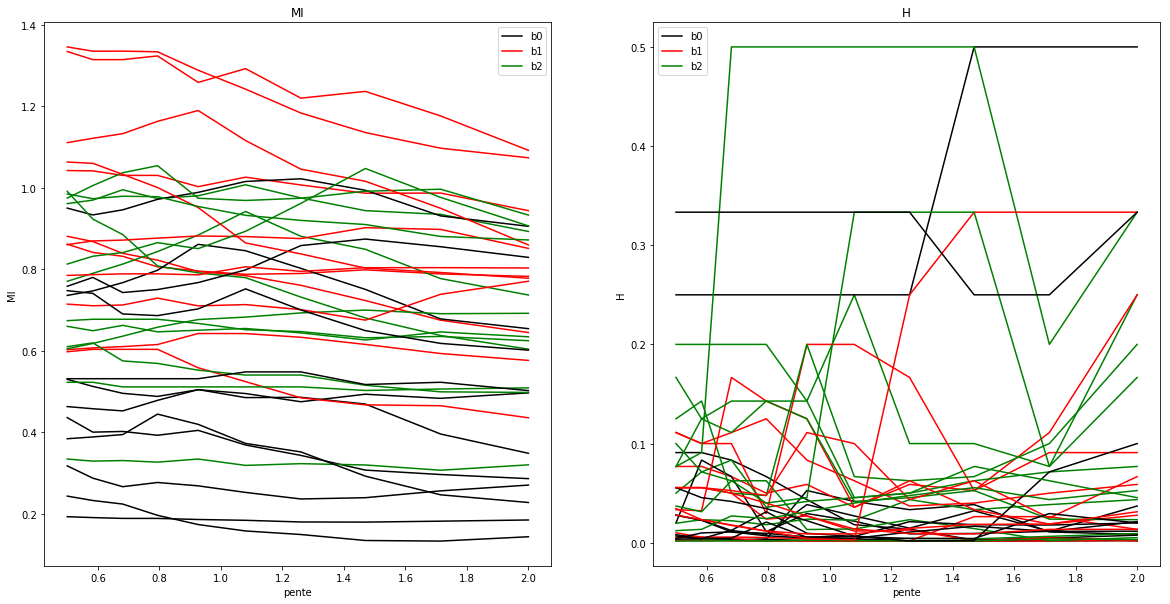

CS LB BMC OP AM RS TN SR YK FM DC IP 

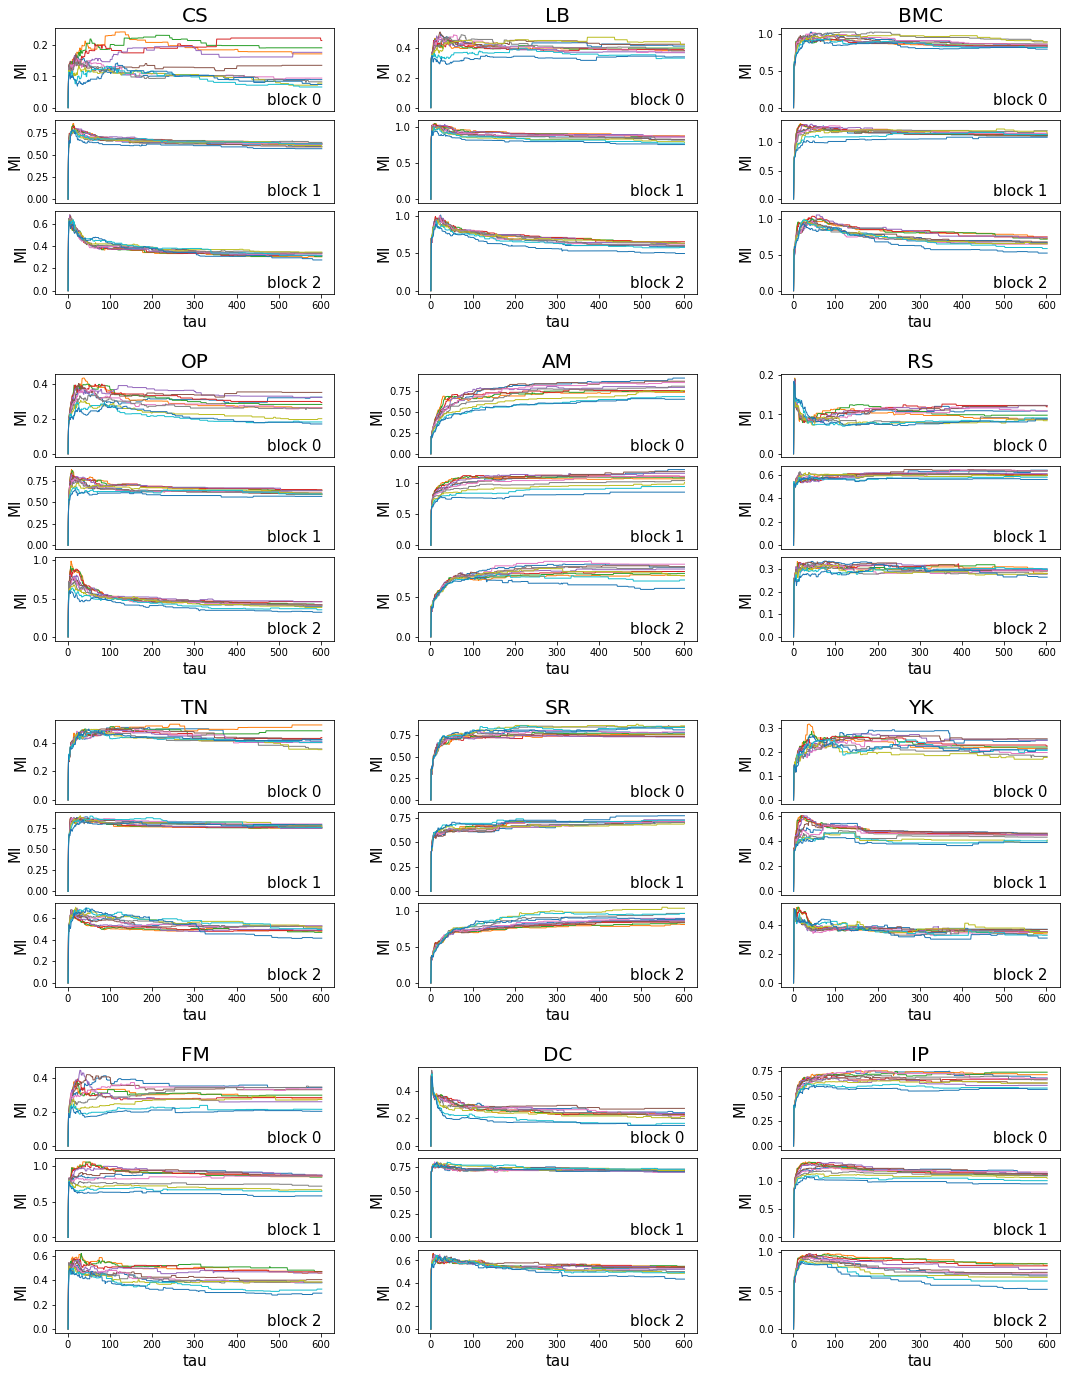

CS LB BMC OP AM RS TN SR YK FM DC IP 

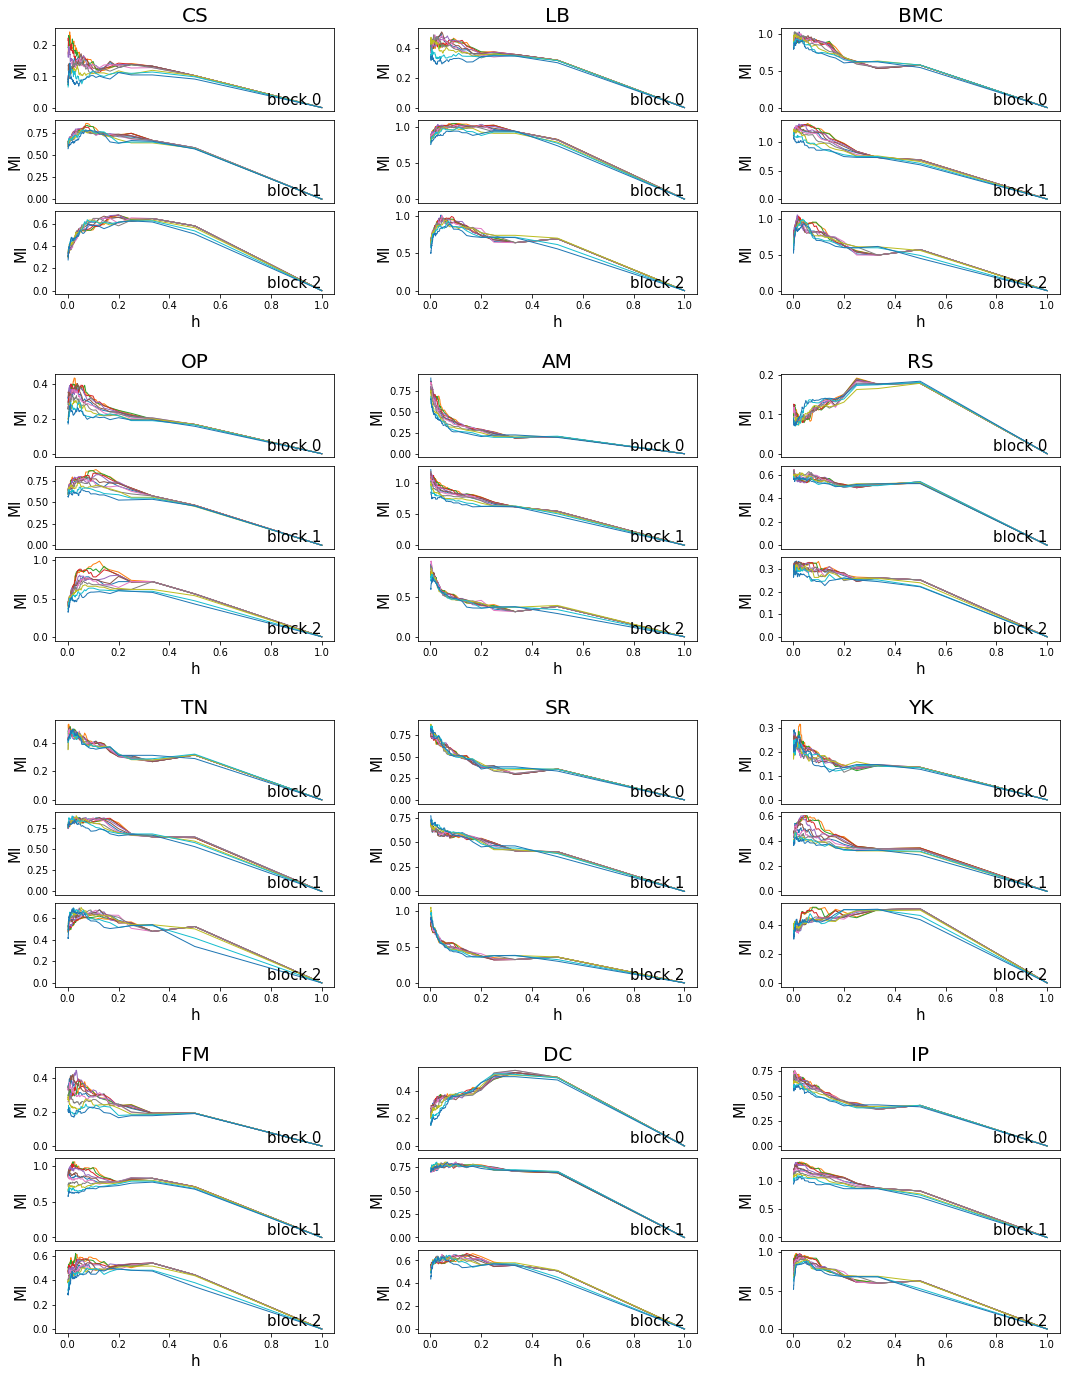

In [12]:
import pickle
file = os.path.join('parametre/list_h', 'list_MI_bet_logit_200.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
h_k_s, r_k_s = find_h_r(recording)
fig_R_pente(h_k_s, r_k_s, r=False)
plot_R(recording, 1/recording['list_h'], 'tau', r=False) 
plot_R(recording, recording['list_h'], 'h', r=False) 

s02 s11 s07 s04 s03 s06 s05 s09 s10 s12 s08 s01 
sans logit|avec logit (max r)

		Block 0			Block 1			Block 2
-------------------------------------------------------------------------------------
s02	k:	         |0.794		        |0.500		        |0.500
	h(tau):	0.017(59)|0.021(47)	0.017(59)|0.059(17)	0.027(37)|0.021(47)
	r:	0.991    |1.018		   1.254|1.268		   0.941|0.963
-------------------------------------------------------------------------------------
s11	k:	         |2.000		        |1.470		        |1.714
	h(tau):	0.042(24)|0.020(49)	0.111(9)|0.027(37)	0.045(22)|0.032(31)
	r:	0.467    |0.484		   0.842|0.847		   0.662|0.700
-------------------------------------------------------------------------------------
s07	k:	         |1.000		        |1.000		        |1.000
	h(tau):	0.018(57)|0.018(57)	0.200(5)|0.200(5)	0.045(22)|0.045(22)
	r:	0.548    |0.548		   1.009|1.009		   0.977|0.977
-------------------------------------------------------------------------------------
s03	k:	         |0.68

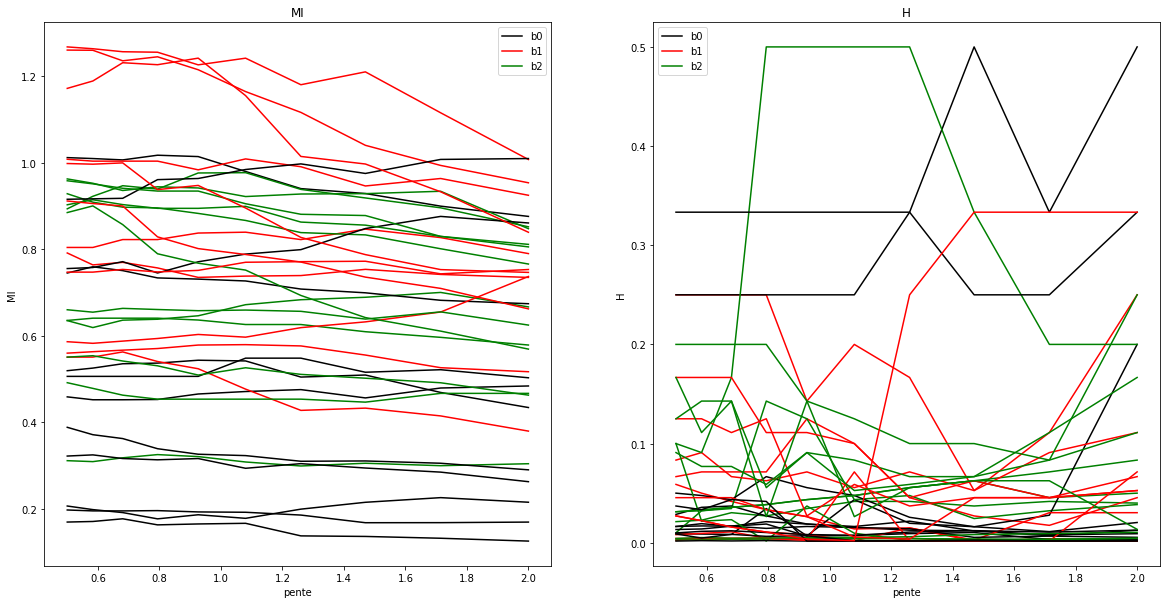

s02 s11 

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


s07 s04 s03 s06 s05 s09 s10 s12 s08 s01 

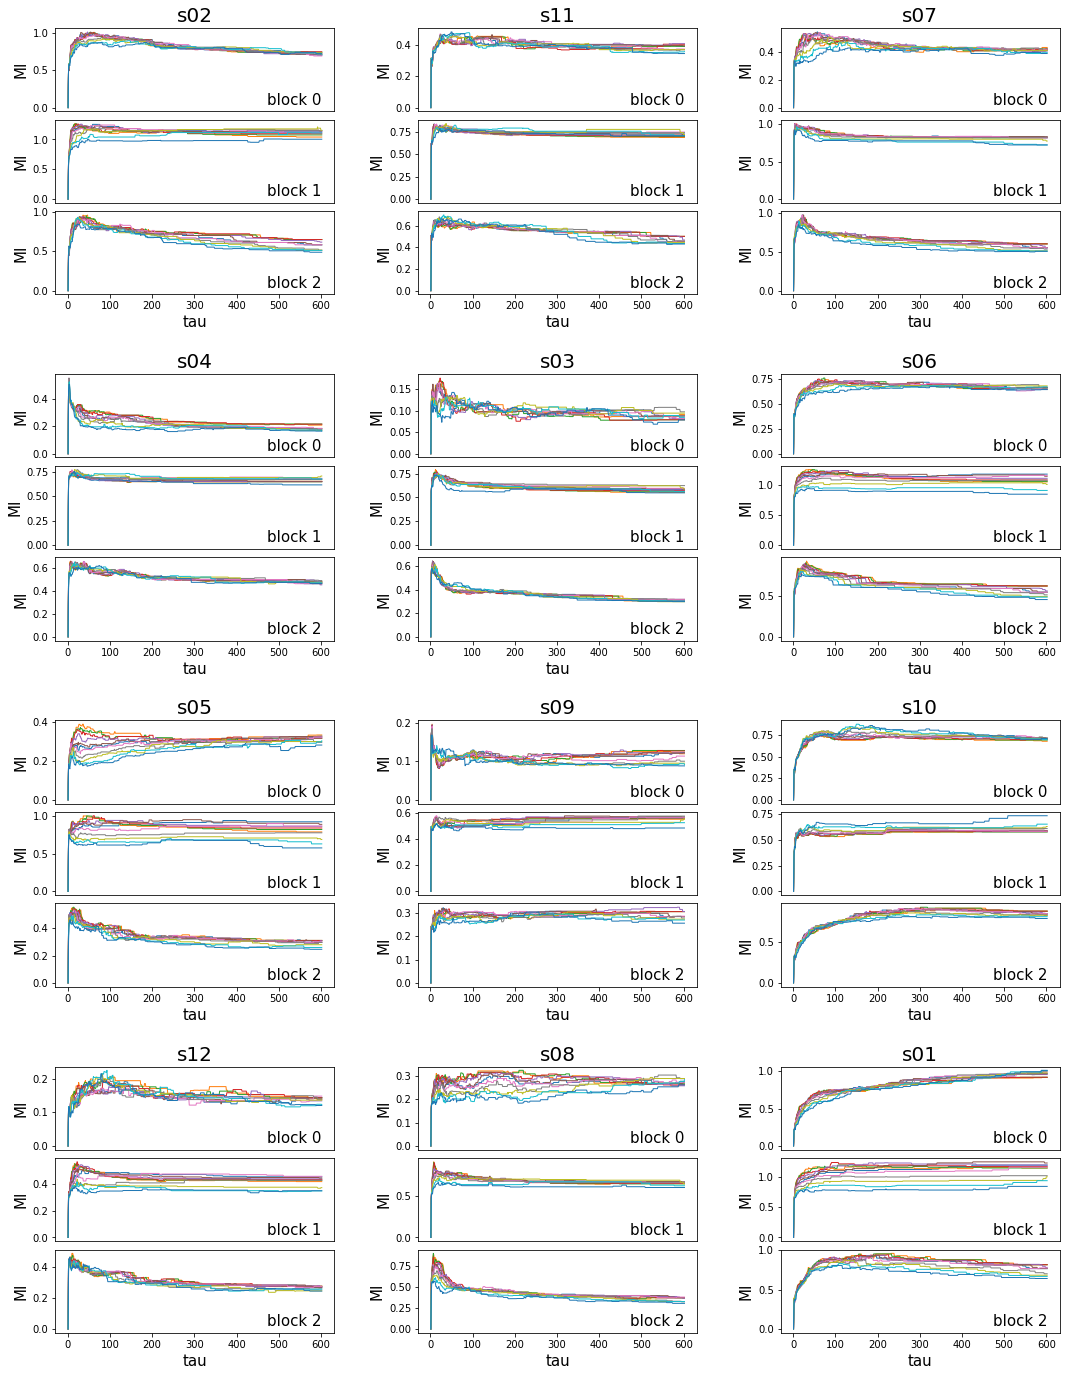

s02 s11 s07 s04 s03 s06 s05 s09 s10 s12 s08 s01 

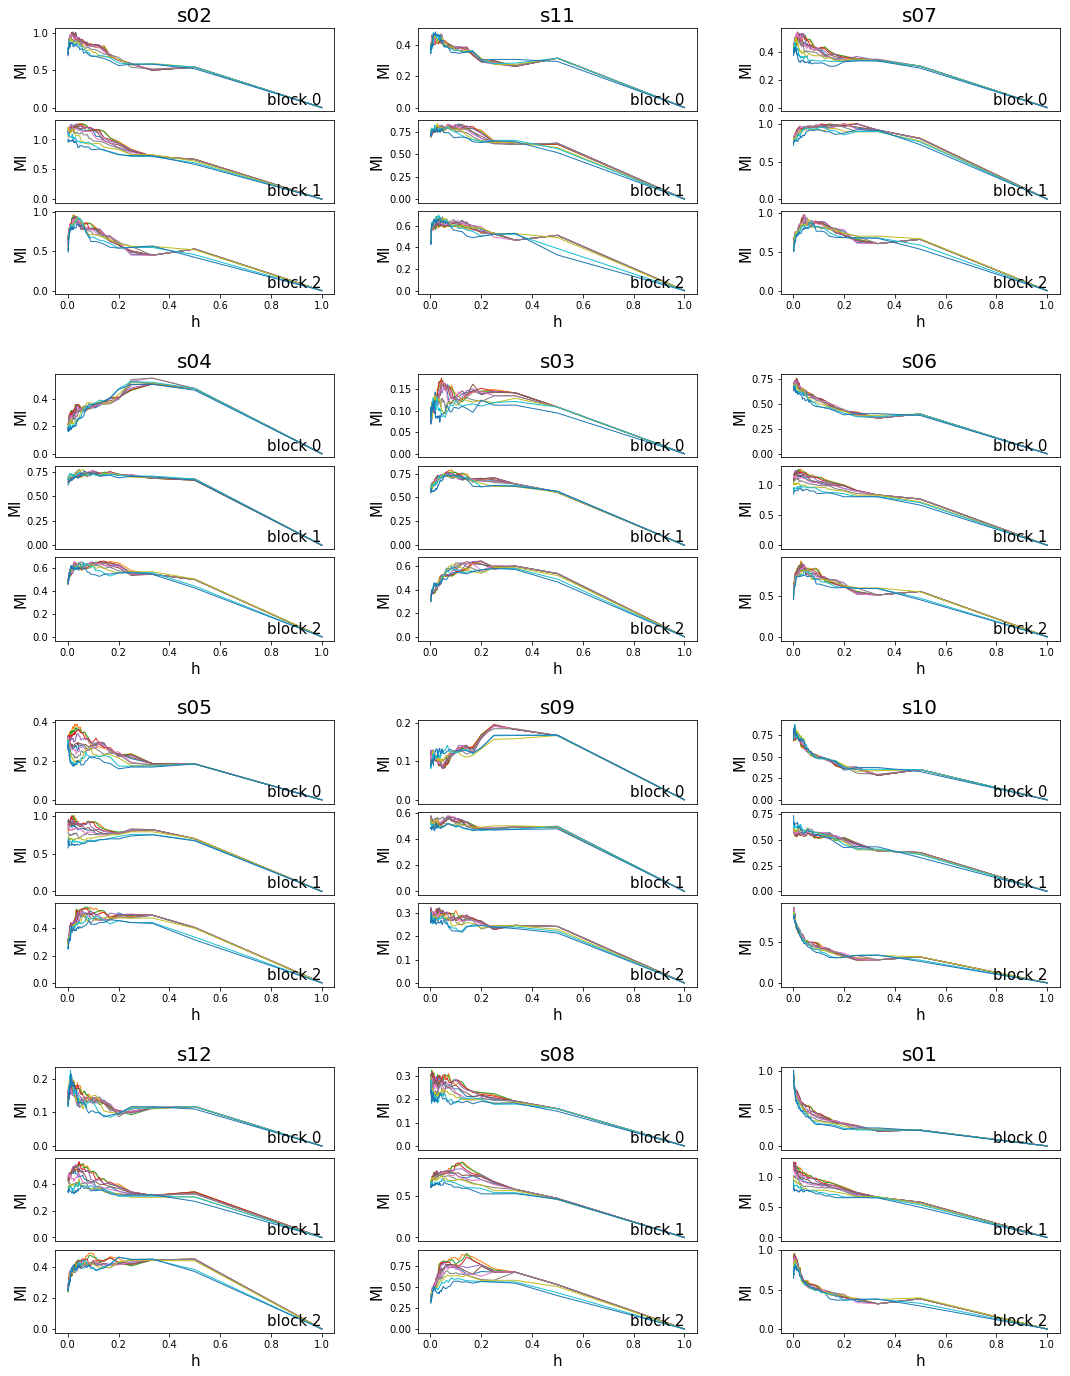

In [12]:
import pickle
file = os.path.join('parametre/list_h', 'list_MI_bet_logit_200_ss_pauses.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
h_k_s, r_k_s = find_h_r(recording)
fig_R_pente(h_k_s, r_k_s, r=False)
plot_R(recording, 1/recording['list_h'], 'tau', r=False) 
plot_R(recording, recording['list_h'], 'h', r=False)